## Predicting energy consumption for one station

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


## Connecting to the database

In [3]:
import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="34.171.207.247",
    database="localai",
    user="postgres",
    password="pglocalai"
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM station_data_hour"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())


   location_id location_friendlyname location_friendlycode  \
0       168298          Nadin Sjever           HRHEP-23004   
1       168298          Nadin Sjever           HRHEP-23004   
2       168298          Nadin Sjever           HRHEP-23004   
3       168298          Nadin Sjever           HRHEP-23004   
4       168298          Nadin Sjever           HRHEP-23004   

  location_address_cityname  location_address_postnumber  \
0                  Benkovac                        23420   
1                  Benkovac                        23420   
2                  Benkovac                        23420   
3                  Benkovac                        23420   
4                  Benkovac                        23420   

  location_address_streetname location_address_housenumber  \
0                       Nadin                           bb   
1                       Nadin                           bb   
2                       Nadin                           bb   
3                 

Below is a function using pandas that takes as input the ID of the location and the path to the .csv file and returns all rows that correspond to the provided location

In [4]:
def filter_csv_by_first_column(df, value):
    '''inputs: csv_file - file with measurements (from database), value - ID'''
        
    # Filter rows based on the first column value, save the name of the station
    filtered_df = df[df.iloc[:, 0] == value]
    name = str(filtered_df.iloc[0, 1])
    print('Station: ', name)
    
    # eliminate the columns 1 to 6 that pertain to the location (address, street number etc.) 
    filtered_df = filtered_df.iloc[:, 7:]
    
    return filtered_df, name


In [5]:
# Provide the dataframe from database
data_stations = df.copy()

# Get the user-provided value to filter on
location_id_opatija = 238016        # Opatija
location_id_zg = 140631             # ZG Autobusni K
location_id_os = 171122             # Osijek

* Opatija - coastal Croatia
* Zagreb - capital city
* Osijek - continental Croatia

In [6]:
# Call the function to filter the CSV
filtered_data_op, name1  = filter_csv_by_first_column(data_stations, location_id_opatija)
filtered_data_zg, name2 = filter_csv_by_first_column(data_stations, location_id_zg)
filtered_data_os, name3 = filter_csv_by_first_column(data_stations, location_id_os)

Station:  Opatija Verdieva
Station:  Zagreb Autobusni
Station:  Osijek Kolarićev vijenac


In [7]:
filtered_data_op 
# this is just to visualize the data

,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
196328,Public access - Free access,2021-08-11 20:00:00+00:00,7.500000,2,0,0.514912,9
196329,Public access - Free access,2021-08-11 21:00:00+00:00,50.000000,2,1,3.432748,60
196330,Public access - Free access,2021-08-11 22:00:00+00:00,40.833333,2,0,2.803411,49
196331,Public access - Free access,2021-08-12 10:00:00+00:00,0.833333,2,0,0.135789,1
196332,Public access - Free access,2021-08-12 12:00:00+00:00,41.666667,2,0,9.024196,50
...,...,...,...,...,...,...,...
197950,Public access - Free access,2022-10-26 02:00:00+00:00,2.500000,2,0,0.509155,3
197951,Public access - Free access,2022-10-28 12:00:00+00:00,23.333333,2,0,5.165161,28
197952,Public access - Free access,2022-10-30 19:00:00+00:00,45.000000,2,0,9.024306,54
197953,Public access - Free access,2022-10-30 20:00:00+00:00,50.000000,2,1,10.027007,60


### Create histograms

In [8]:
def create_histogram(dataframe1, dataframe2, dataframe3):
    # each of the histograms was saved as a .png file - it is commented since it is not necessary in production
    
    # Get the data from the column energy consumption
    last_column_data1 = dataframe1['energy_consumption']
    
    # Create a histogram for first station
    plt.hist(last_column_data1)
    plt.xlabel('Energy Consumption')
    plt.ylabel('Frequency')
    plt.title('Histogram of Energy Consumption, Opatija')
    plt.savefig('Histogram Opatija.png')
    plt.show()
    
    last_column_data2 = dataframe2['energy_consumption']
    
    # Create a histogram for the second station
    plt.hist(last_column_data2, color='g')
    plt.xlabel('Energy Consumption')
    plt.ylabel('Frequency')
    plt.title('Histogram of Energy Consumption, Zagreb')
    plt.savefig('Histogram Zagreb.png')
    plt.show()
    
    last_column_data3 = dataframe3['energy_consumption']
    
    # Create a histogram for the third station
    plt.hist(last_column_data3, color='r')
    plt.xlabel('Energy Consumption')
    plt.ylabel('Frequency')
    plt.title('Histogram of Energy Consumption, Osijek')
    plt.savefig('Histogram Osijek.png')
    plt.show()
    
    # Create a histogram for all the stations together
    plt.hist([last_column_data1.values.flatten(), last_column_data2.values.flatten(), last_column_data3.values.flatten()], label=['Opatija', 'Zagreb', 'Osijek'])
    plt.legend()
    #plt.rc('xtick', labelsize=15)
    #plt.rc('ytick', labelsize=15)
    plt.xlabel('Energy Consumption')
    plt.ylabel('Frequency')
    plt.title('Histogram of Energy Consumption')
    plt.savefig('Histogram consumption.png')
    plt.show()

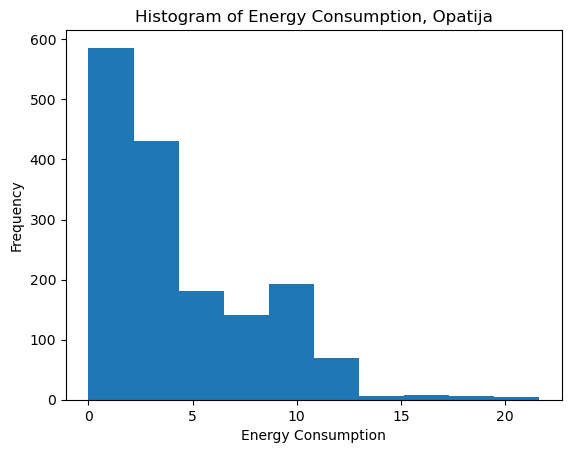

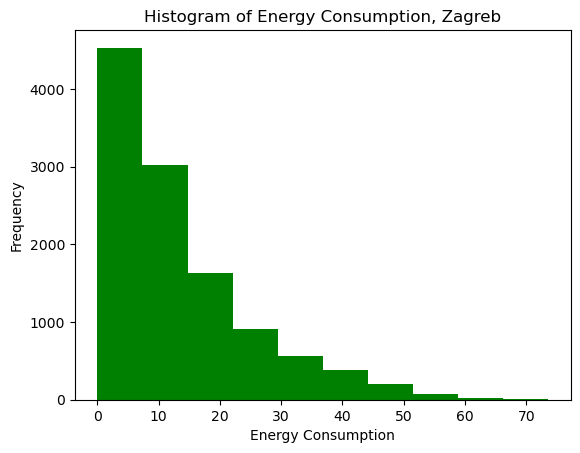

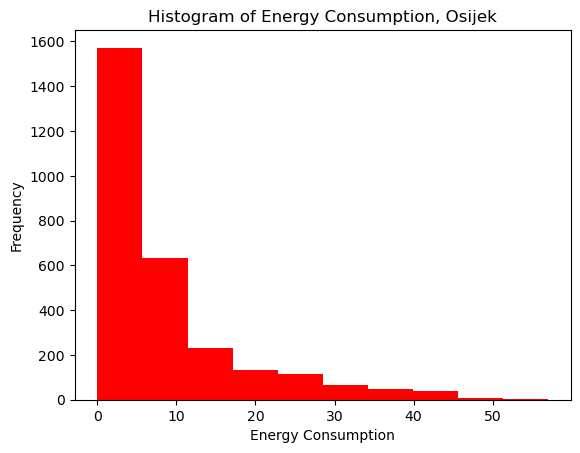

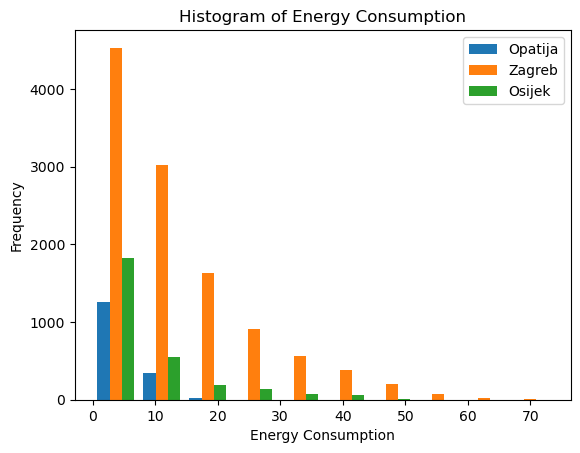

In [9]:
create_histogram(filtered_data_op, filtered_data_zg, filtered_data_os)

### Expand data and plot measurements

In [10]:
def expand_data(dataframe, name):
    '''inputs: original dataframe with values for ONE station'''
    
    dataframe_copy = dataframe.copy()
    
    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)
    
    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')
    
    dataframe_copy.set_index('Time', inplace=True)
    
    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')
    
    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)
    
    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan) 
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)
    
    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')
    
    # expanded dataframe is returned
    return new_dataframe
    
    
    

In [12]:
expanded_data_op = expand_data(filtered_data_op, name1)
# expanded_data_zg = expand_data(filtered_data_zg, name2)
# expanded_data_os = expand_data(filtered_data_os, name3)
expanded_data_op

       utilization  connector_count  congested_connectors  energy_consumption  \
count  1627.000000           1627.0           1627.000000         1627.000000   
mean     42.302295              2.0              0.612784            4.399252   
std      21.296356              0.0              0.553449            3.724568   
min       0.000000              2.0              0.000000            0.000000   
25%      27.500000              2.0              0.000000            1.346151   
50%      50.000000              2.0              1.000000            3.204889   
75%      50.000000              2.0              1.000000            6.799889   
max     100.000000              2.0              2.000000           21.649773   

       charging_minutes  
count       1627.000000  
mean          50.762754  
std           25.555627  
min            0.000000  
25%           33.000000  
50%           60.000000  
75%           60.000000  
max          120.000000  


,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
2021-08-11 00:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2021-08-11 01:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2021-08-11 02:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2021-08-11 03:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2021-08-11 04:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-10-29 20:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-10-29 21:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-10-29 22:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-10-29 23:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0


In [35]:
def create_data_plots(dataframe1, dataframe2, dataframe3):
    '''inputs are three dataframes that correspond to the three locations, but this can be changed to only one dataframe'''
        
    # Get the data from the wanted columns - energy consumption and utilization
    cons_column_data1 = dataframe1['energy_consumption']
    util_column_data1 = dataframe1['utilization']
    time = dataframe1.index
    
    fig, ax1 = plt.subplots(figsize=(20, 12))

    ax2 = ax1.twinx()
    ax1.plot(time, util_column_data1, 'crimson')
    ax2.plot(time, cons_column_data1, 'teal')

    ax1.set_xlabel('Timesteps', fontsize=20)
    ax1.set_ylabel('Utilization', color='crimson', fontsize=20)
    ax2.set_ylabel('Consumption', color='teal', fontsize=20)
    plt.title('Values of energy consumption and utilization, Opatija', fontsize=20)
    plt.savefig('Mjerenja output Opatija.png')
    plt.show()
    
    
    cons_column_data2 = dataframe2['energy_consumption']
    util_column_data2 = dataframe2['utilization']
    time2 = dataframe2.index
    
    fig, ax1 = plt.subplots(figsize=(20, 12))

    ax2 = ax1.twinx()
    ax1.plot(time2, util_column_data2, 'crimson')
    ax2.plot(time2, cons_column_data2, 'teal')

    ax1.set_xlabel('Timesteps', fontsize=20)
    ax1.set_ylabel('Utilization', color='crimson', fontsize=20)
    ax2.set_ylabel('Consumption', color='teal', fontsize=20)
    plt.title('Values of energy consumption and utilization, Zagreb', fontsize=20)
    plt.savefig('Mjerenja output Zagreb.png')
    plt.show()
    
        
    cons_column_data3 = dataframe3['energy_consumption']
    util_column_data3 = dataframe3['utilization']
    time3 = dataframe3.index
    
    fig, ax1 = plt.subplots(figsize=(20, 12))

    ax2 = ax1.twinx()
    ax1.plot(time3, util_column_data3, 'crimson')
    ax2.plot(time3, cons_column_data3, 'teal')

    ax1.set_xlabel('Timesteps', fontsize=20)
    ax1.set_ylabel('Utilization', color='crimson', fontsize=20)
    ax2.set_ylabel('Consumption', color='teal', fontsize=20)
    plt.title('Values of energy consumption and utilization, Osijek', fontsize=20)
    plt.savefig('Mjerenja output Osijek.png')
    plt.show()
    

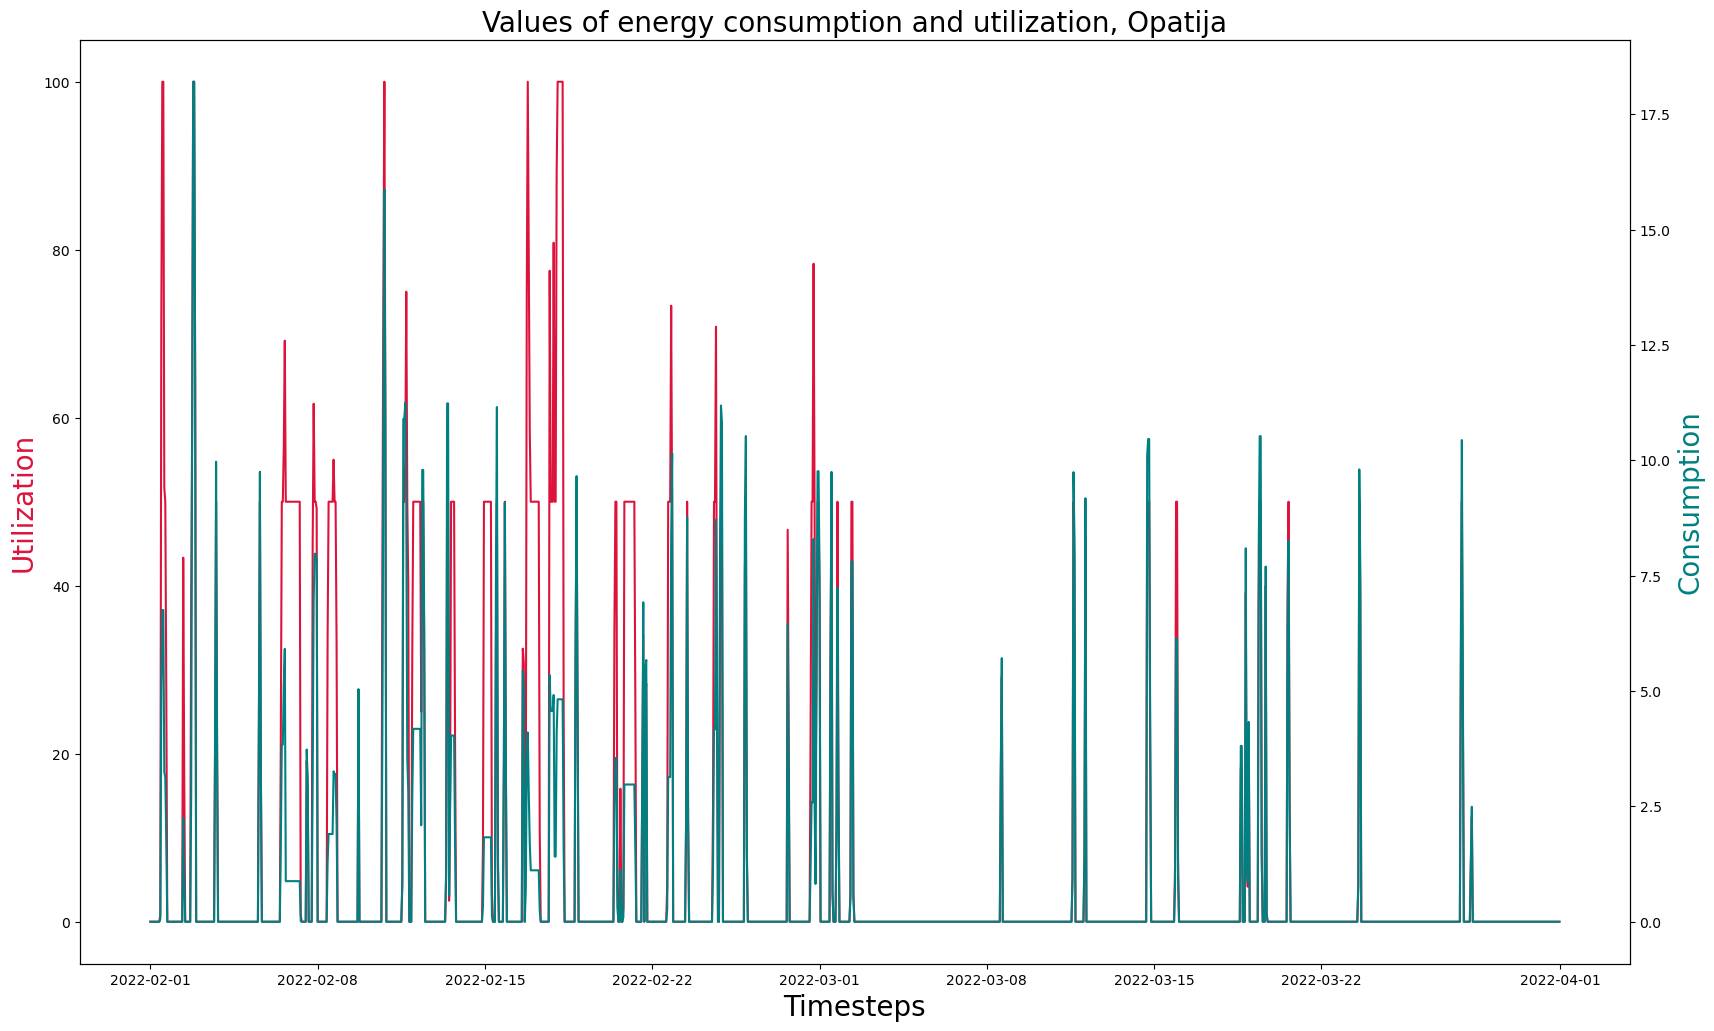

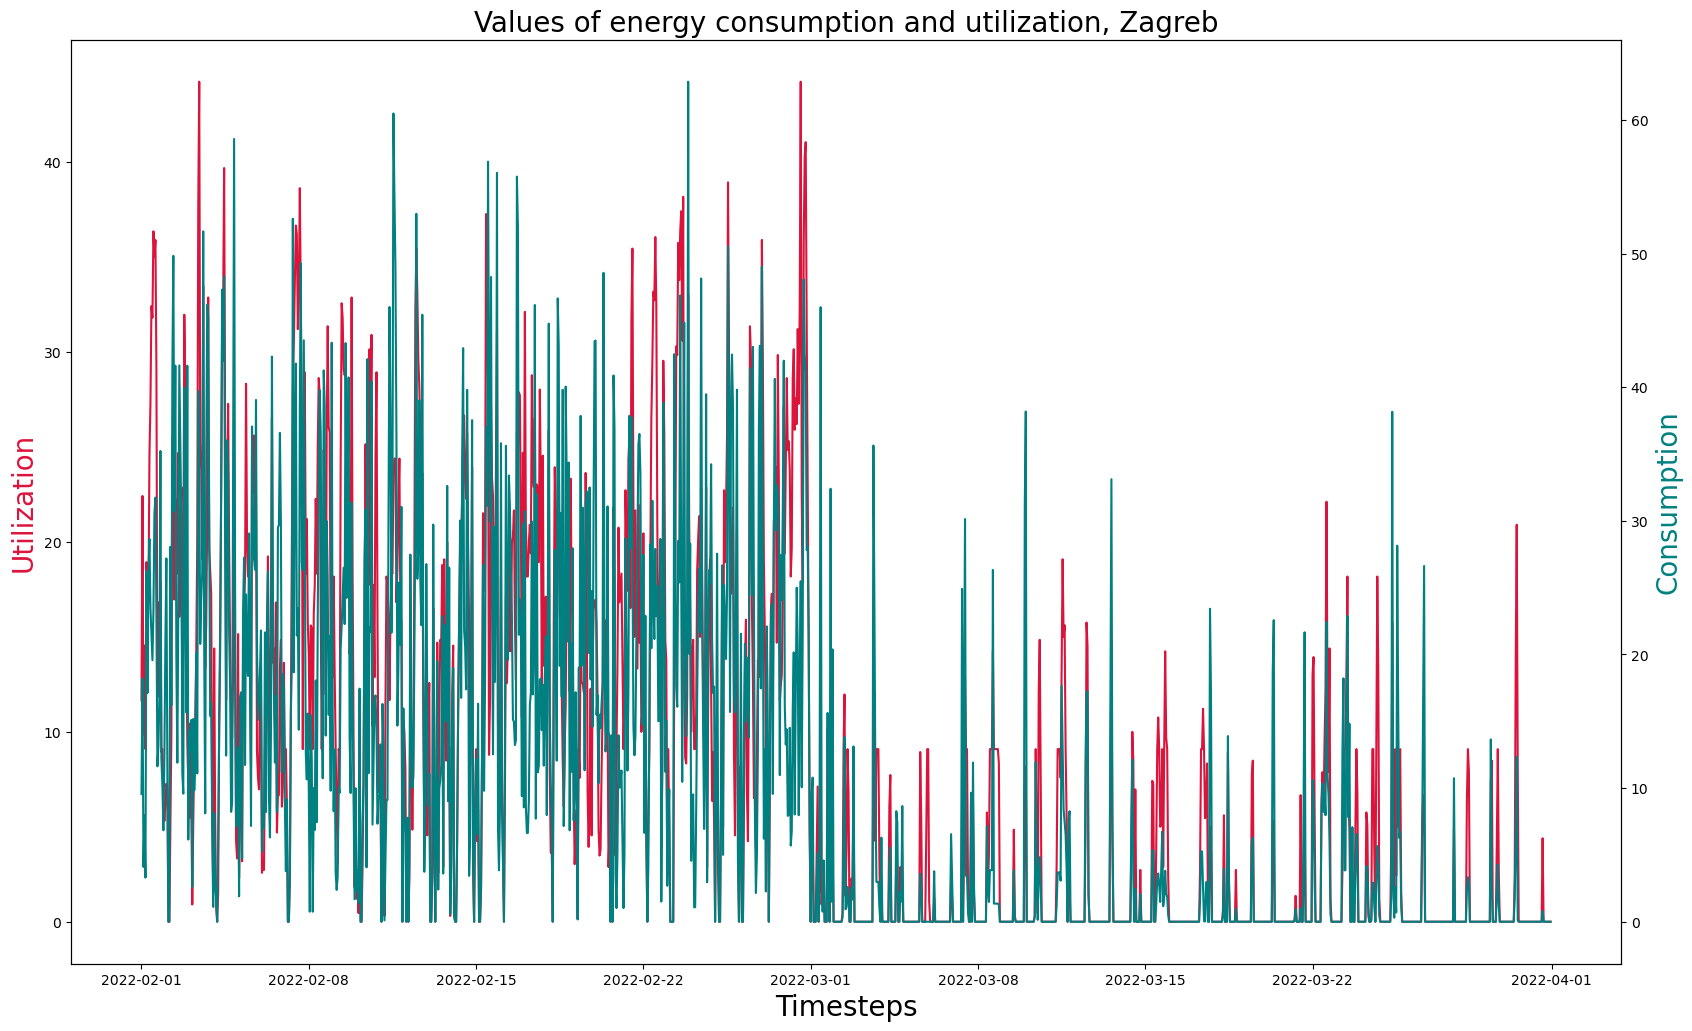

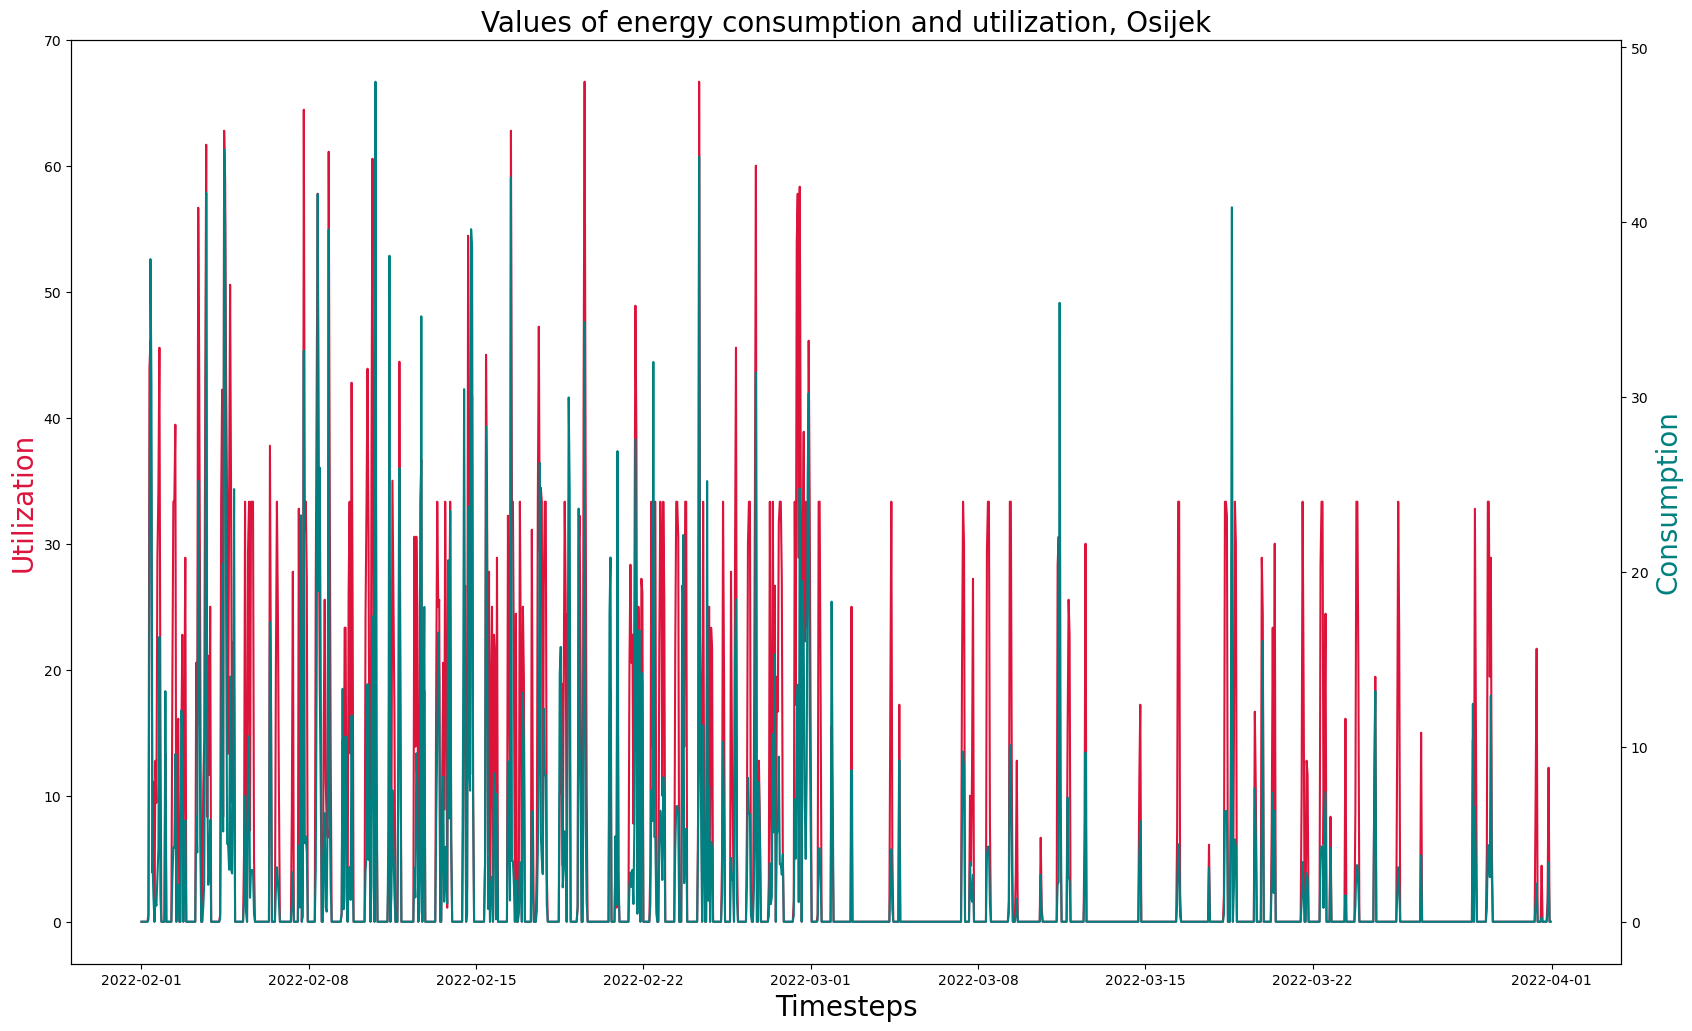

In [36]:
create_data_plots(expanded_data_op.loc['2022-02-01':'2022-03-31'], expanded_data_zg.loc['2022-02-01':'2022-03-31'], expanded_data_os.loc['2022-02-01':'2022-03-31'])

In [37]:
expanded_data_zg

,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
2019-09-13 00:00:00,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2019-09-13 01:00:00,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2019-09-13 02:00:00,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2019-09-13 03:00:00,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2019-09-13 04:00:00,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...
2022-10-30 20:00:00,Public access - Free access,2022-10-30 20:00:00+00:00,2.575758,11.0,0.0,12.415877,17.0
2022-10-30 21:00:00,Public access - Free access,2022-10-30 21:00:00+00:00,3.181818,11.0,0.0,15.337260,21.0
2022-10-30 22:00:00,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2022-10-30 23:00:00,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0


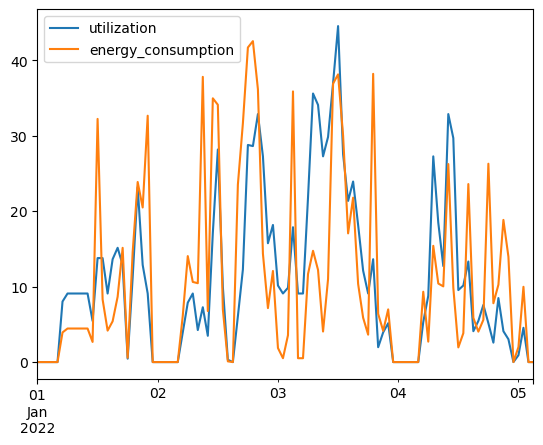

In [12]:
expanded_data_zg['utilization'][:100].plot()
expanded_data_zg['energy_consumption'][:100].plot()
plt.legend()

### Data preparation

In [13]:
filter_data = expanded_data_op.copy() # here we selected which of the three stations is used
# in this case only measurements corresponding to the Opatija charging station is included

In [14]:
# dataframe is separated in train, val and test set (80% / 10% / 10%)
train_size = int(len(filter_data) * 0.8)
val_size = int(len(filter_data) * 0.1)
test_size = len(filter_data) - train_size - val_size
train_data, val_data, test_data = filter_data.iloc[:train_size], filter_data.iloc[train_size:train_size + val_size], filter_data.iloc[train_size + val_size:]

In [15]:
train_data

,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
2021-08-11 00:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2021-08-11 01:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2021-08-11 02:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2021-08-11 03:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2021-08-11 04:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-08-01 19:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-08-01 20:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-08-01 21:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-08-01 22:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0


In [16]:
val_data

,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
2022-08-02 00:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-08-02 01:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-08-02 02:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-08-02 03:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-08-02 04:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-09-15 07:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-09-15 08:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-09-15 09:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-09-15 10:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0


In [17]:
test_data

,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
2022-09-15 12:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-09-15 13:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-09-15 14:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-09-15 15:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-09-15 16:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-10-29 20:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-10-29 21:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-10-29 22:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0
2022-10-29 23:00:00,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0


In [19]:
# here dataset is transformed - new features are added and unnecessary features are removed
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe):
        
        # Extract year, month, and day from the timestamp
        dataframe['Year'] = pd.to_datetime(dataframe.index).year
        dataframe['Month'] = pd.to_datetime(dataframe.index).month
        dataframe['Day'] = pd.to_datetime(dataframe.index).dayofweek
        
        # Convert year to the number of years since 1970
        dataframe['Year'] = dataframe['Year'] - 1970
        #print(dataframe)
        # One-hot encode the month
        dataframe = pd.get_dummies(dataframe, columns=['Month'])
        
        num_months = (dataframe.filter(regex='Month_')).shape[-1]
        
        # if there are less than 12 months in dataset (for example, if training dataset consists of only 9 months)
        # this if condition adds columns for all the months - in case there are missing months, these columns are filled with zeros
        if num_months < 12:
            list_existing_months = dataframe.filter(regex='Month_').columns
            list_all_months = [f'Month_{i}' for i in range(1, 13)]
            list_non_existing_months = [x for x in list_all_months if x not in list_existing_months]
            for i in list_non_existing_months:
                dataframe[i] = 0
            #print(dataframe)
            
        # print(dataframe)
        
        # Transform day of the week into the corresponding weekday
        weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dataframe['Day'] = dataframe['Day'].apply(lambda x: weekdays[x])
        
        # One-hot encode the day
        dataframe = pd.get_dummies(dataframe, columns=['Day'])
        
        # TO DO here: add location encoding
        
        # Convert 'public access' to 1 and 'private access' to 0
        dataframe.iloc[:, 0] = (dataframe.iloc[:, 0] == 'Public access - Free access').astype('float32')
        dataframe.drop(columns='charging_hour', axis=1, inplace=True)
        
        # Convert the label column to a tensor - labels have 2 features (energy consumption and utilization)
        labels = torch.tensor(dataframe[['energy_consumption', 'utilization']].values, dtype=torch.float32)
                
        # Convert the features columns to tensors - features are all the other columns
        features = torch.tensor(dataframe[dataframe.columns.difference(['energy_consumption', 'utilization'])].values, dtype=torch.float32)
        
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [20]:
train_data_filtered = TimeSeriesDataset(train_data)
val_data_filtered = TimeSeriesDataset(val_data)
test_data_filtered = TimeSeriesDataset(test_data)

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_24028\3876445912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.to_datetime(dataframe.index).year
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_24028\3876445912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.to_datetime(dataframe.index).month
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_24028\3876445912.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [21]:
train_data[['energy_consumption', 'utilization']]

,energy_consumption,utilization
2021-08-11 00:00:00,0.0,0.0
2021-08-11 01:00:00,0.0,0.0
2021-08-11 02:00:00,0.0,0.0
2021-08-11 03:00:00,0.0,0.0
2021-08-11 04:00:00,0.0,0.0
...,...,...
2022-08-01 19:00:00,0.0,0.0
2022-08-01 20:00:00,0.0,0.0
2022-08-01 21:00:00,0.0,0.0
2022-08-01 22:00:00,0.0,0.0


In [22]:
test_data_filtered.labels.shape

torch.Size([1069, 2])

In [23]:
val_data_filtered.features.shape

torch.Size([1068, 24])

In [24]:
train_data_filtered.labels

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [26]:
train_loader = DataLoader(train_data_filtered, batch_size = 256, shuffle=False)
train_loader.dataset.features.shape

torch.Size([8544, 24])

In [27]:
val_loader = DataLoader(val_data_filtered, batch_size = 256, shuffle=False)
val_loader.dataset.features.shape

torch.Size([1068, 24])

In [28]:
test_loader = DataLoader(test_data_filtered, batch_size = 256, shuffle=False)
test_loader.dataset.features.shape

torch.Size([1069, 24])

In [137]:
for x,y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([256, 24]) torch.Size([256, 2])


## LSTM model

In [192]:
# Define the LSTM network
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.fc(output)
        #print('Shape: ', output.shape)
        return output, hidden


In [112]:
# I was using this part of the code - better results
class LSTM_TimeSeries(nn.Module): # Should always inherit from nn.Module parent class
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super().__init__() # class super constructor
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layer_size, batch_first=True) # lstm consisting of 3 layers
        self.linear = nn.Linear(hidden_size, output_size) # final linear layer on top
        
    def forward(self, x): # forward pass in the neural network
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [31]:
# Function to calculate the mean squared error
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true.detach().numpy(), y_pred.detach().numpy())


In [212]:
dict_lstm_models_op = {}
# this dictionary is used to save results (train and val loss, predictions, etc.)

In [213]:
dict_lstm_models_op['Setup 5'] = {}

In [71]:
dict_lstm_models_op['Setup 1']['Parameters'] = {'batch size': 128,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 16,
                                               'num hidden layers': 1,
                                               'optimizer': 'RMSprop'}


In [111]:
dict_lstm_models_op['Setup 2']['Parameters'] = {'batch size': 64,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 32,
                                               'num hidden layers': 1,
                                               'optimizer': 'RMSprop'}

In [130]:
dict_lstm_models_op['Setup 3']['Parameters'] = {'batch size': 256,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 16,
                                               'num hidden layers': 2,
                                               'optimizer': 'RMSprop'}

In [147]:
dict_lstm_models_op['Setup 4']['Parameters'] = {'batch size': 256,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 32,
                                               'num hidden layers': 2,
                                               'optimizer': 'RMSprop'}

In [214]:
dict_lstm_models_op['Setup 5']['Parameters'] = {'batch size': 256,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 64,
                                               'num hidden layers': 2,
                                               'optimizer': 'RMSprop'}

In [96]:
dict_lstm_models_op['Setup 6']['Parameters'] = {'batch size': 256,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 128,
                                               'num hidden layers': 2,
                                               'optimizer': 'RMSprop'}

In [72]:
dict_lstm_models_op['Setup 1']['Results'] = {} 

In [112]:
dict_lstm_models_op['Setup 2']['Results'] = {} 

In [131]:
dict_lstm_models_op['Setup 3']['Results'] = {} 

In [148]:
dict_lstm_models_op['Setup 4']['Results'] = {} 

In [210]:
dict_lstm_models_op['Setup 5']['Results'] = {} 

In [215]:
dict_lstm_models_op.keys()

dict_keys(['Setup 5'])

In [216]:
# these are additional lists and dataframes that are used to save results
train_loss_list = []
train_mse_list = []
test_loss_list = []
test_mse_list = []
epoch_list = []
predicted_values_consumption = pd.DataFrame()
predicted_values_utilization = pd.DataFrame()
real_values_consumption = pd.DataFrame()
real_values_utilization = pd.DataFrame()

pred_consumption_test = pd.DataFrame()
pred_utilization_test = pd.DataFrame()
real_consumption_test = pd.DataFrame()
real_utilization_test = pd.DataFrame()


In [217]:
# Define the LSTM network
from torch.utils.data import DataLoader
input_size = train_data_filtered.features.size(1) # num of features
hidden_size = 64
layer_size = 2
output_size = 2
#model = LSTMNet(input_size, hidden_size, layer_size, output_size)
model = LSTM_TimeSeries(input_size, hidden_size, layer_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2000

counter = 0 # is used only for early stopping
for epoch in range(num_epochs):

    train_loss = 0.0
    val_loss = 0.0
    train_mse = 0.0
    val_mse = 0.0
    
    # Initialize hidden state
    #hidden = None
    
    # Training
    model.train()
    for inputs, labels in train_loader:
        #print(inputs.unsqueeze(2).shape)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_mse += calculate_mse(labels, outputs)
        #print('Train loss:', loss.item())

    # Testing
    model.eval()
    
    # *_pom1 is a list that is used for storing values related to the energy consumption
    # *_pom2 is a list that is used for storing values related to the utilization
    predicted_values_pom1 = []
    predicted_values_pom2 = []
    real_values_pom1 = []
    real_values_pom2 = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            # print('Outputs shape: ', outputs.squeeze().shape)
            predicted_values_pom1 += outputs.squeeze().numpy()[:, 0].tolist()
            predicted_values_pom2 += outputs.squeeze().numpy()[:, 1].tolist()
            real_values_pom1 += labels.numpy()[:, 0].tolist()
            real_values_pom2 += labels.numpy()[:, 1].tolist()
            val_loss += loss.item() * inputs.size(0)
            val_mse += calculate_mse(labels, outputs)
            
    if epoch%50 == 0:
        # Print training and test errors
        print(f"Epoch {epoch}/{num_epochs} - Training Loss: {train_loss/train_size:.4f} - Val Loss: {val_loss/val_size:.4f} - Train MSE: {train_mse/train_size:.4f} - Val MSE: {val_mse/val_size:.4f}")
        train_loss_list.append(train_loss/train_size)
        train_mse_list.append(train_mse/train_size)
        test_loss_list.append(val_loss/val_size)
        test_mse_list.append(val_mse/val_size)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        
    if epoch == 0:
        real_values_consumption['Epoch ' + str(epoch)] = real_values_pom1
        real_values_utilization['Epoch ' + str(epoch)] = real_values_pom2
        
        # in the first epoch, the calculated losses are considered minimal -> in later epochs it is checked whether the loss is reducing
        val_loss_old = (val_loss/val_size)
        min_val_loss = val_loss_old
        min_weights = model.state_dict()
        
    if epoch > 0:
        val_loss_new = val_loss/val_size
        if val_loss_new > min_val_loss: # some kind of an Early Stopping callback
            counter += 1
        else:
            predicted_values_consumption['The best epoch'] = predicted_values_pom1
            predicted_values_utilization['The best epoch'] = predicted_values_pom2
            min_val_loss = val_loss_new
            min_weights = model.state_dict()

    if counter == 8: 
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train MSE: {train_mse/train_size:.4f} - Val MSE: {val_mse/val_size:.4f}")
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train loss: {train_loss/train_size:.4f} - Val loss: {val_loss/val_size:.4f}")
        print('Minimum validation loss: ', min_val_loss)
        print('Current validation loss: ', val_loss_new)
        train_loss_list.append(train_loss/train_size)
        train_mse_list.append(train_mse/train_size)
        test_loss_list.append(val_loss/val_size)
        test_mse_list.append(val_mse/val_size)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        break
    


    

Epoch 0/2000 - Training Loss: 152.9949 - Val Loss: 61.8549 - Train MSE: 0.5996 - Val MSE: 0.2645
Epoch 50/2000 - Training Loss: 3.7190 - Val Loss: 1.3664 - Train MSE: 0.0145 - Val MSE: 0.0055
[Early stopping] Epoch 93/2000 - Train MSE: 0.0024 - Val MSE: 0.0021
[Early stopping] Epoch 93/2000 - Train loss: 0.6141 - Val loss: 0.5282
Minimum validation loss:  0.5262468362485202
Current validation loss:  0.5282225608616398


In [218]:
sum(p.numel() for p in model.parameters())

56450

In [118]:
predicted_values_consumption

,Epoch 0,The best epoch,Epoch 50,Epoch 92
0,0.056700,-0.050469,-0.009284,-0.060597
1,0.006454,-0.022613,-0.003780,-0.016885
2,-0.007049,-0.002875,0.002834,0.011511
3,-0.007638,-0.001837,0.006797,0.012529
4,-0.009751,-0.001578,0.007900,0.003716
...,...,...,...,...
1063,-0.029036,0.001481,0.009658,0.000505
1064,-0.029744,0.001481,0.009661,0.000505
1065,-0.030316,0.001482,0.009662,0.000506
1066,-0.030776,0.001483,0.009662,0.000507


In [219]:
# prediction part on the test set
pred_consumption = []
pred_utilization = []
real_consumption = []
real_utilization = []

test_loss = 0.0
test_mse = 0.0

for inputs, labels in test_loader:
    outputs_test = model(inputs)
    loss = criterion(outputs_test.squeeze(), labels)
    # print('Outputs shape: ', outputs.squeeze().shape)
    pred_consumption += outputs_test.squeeze().detach().numpy()[:, 0].tolist()
    pred_utilization += outputs_test.squeeze().detach().numpy()[:, 1].tolist()
    real_consumption += labels.numpy()[:, 0].tolist()
    real_utilization += labels.numpy()[:, 1].tolist()
    test_loss += loss.item() * inputs.size(0)
    test_mse += calculate_mse(labels, outputs_test)

pred_consumption_test['Final'] = pred_consumption
pred_utilization_test['Final'] = pred_utilization
real_consumption_test['Final'] = real_consumption
real_utilization_test['Final'] = real_utilization


In [220]:
pred_consumption_test

,Final
0,-0.120651
1,-0.060414
2,-0.049953
3,-0.031485
4,-0.008540
...,...
1064,-0.000719
1065,-0.000722
1066,-0.000724
1067,-0.000726


In [221]:
# storing of the results
dict_lstm_models_op['Setup 5']['Results'] = {'Train loss': train_loss_list,
                              'Train MSE': train_mse_list,
                              'Test loss': test_loss_list,
                              'Test MSE': test_mse_list,
                              'Epochs': epoch_list,
                              'Predictions consumption validation:': predicted_values_consumption,
                              'Prediction utilization validation:': predicted_values_utilization,
                              'Real values consumption validation:': real_values_consumption,
                               'Real values utilization validation:': real_values_utilization,
                              'Predictions consumption test:': pred_consumption_test,
                              'Prediction utilization test:': pred_utilization_test,
                              'Real values consumption test:': real_consumption_test,
                               'Real values utilization test:': real_utilization_test}

In [174]:
# example of the output
dict_lstm_models_op

{'Setup 1': {'Parameters': {'batch size': 128,
   'learning rate': 0.001,
   'num hidden neurons': 16,
   'num hidden layers': 1,
   'optimizer': 'RMSprop'},
  'Results': {'Train loss': [185.5995711169802,
    57.249614629171916,
    14.523170336109956,
    5.745096208600934,
    1.744325848969488,
    0.6984888929594657,
    0.6984888929594657],
   'Train MSE': [1.451178524124546,
    0.447455343789052,
    0.11346682512556597,
    0.04488828987182268,
    0.01363361224501661,
    0.005464389962330319,
    0.005464389962330319],
   'Test loss': [87.14724074231552,
    21.91371069061622,
    3.827560340420584,
    1.8990365083186367,
    0.9990298838706945,
    0.8575233746919962,
    0.8575233746919962],
   'Test MSE': [0.706296483229162,
    0.175580577903919,
    0.029978158782595552,
    0.014924847942947895,
    0.007861739017543721,
    0.006723183576952429,
    0.006723183576952429],
   'Epochs': [0, 50, 100, 150, 200, 250, 250],
   'Predictions consumption validation:':        

### Plotanje

In [231]:
def plot_everything(dict_model):
    pom_dict_s1 = dict_model['Setup']['Results'].copy()
    
    fig, (ax1, ax2) = plt.subplots(2)
    
    ax1.plot(pom_dict_s1['Epochs'], pom_dict_s1['Train loss'], color='b', label='Train loss')
    ax1.plot(pom_dict_s1['Epochs'], pom_dict_s1['Test loss'], color='g', label='Test loss')
    ax1.set(ylabel='Loss')
    ax1.legend()
    ax1.set_title('Train and test loss and MSE, Transformer model')
    
    ax2.plot(pom_dict_s1['Epochs'], pom_dict_s1['Train MSE'], color='b', label='Train MSE')
    ax2.plot(pom_dict_s1['Epochs'], pom_dict_s1['Test MSE'], color='g', label='Test MSE')
    ax2.set(xlabel = 'Epochs', ylabel = 'MSE')
    ax2.legend()
    
    plt.savefig('Transformer loss, Op.png')
    
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
    
    ax1.plot(pom_dict_s1['Predictions consumption validation:'].iloc[:500, 1], color='b', label='Predicted consumption')
    ax1.plot(pom_dict_s1['Real values consumption validation:'].iloc[:500, 0], color='g', label='Real consumption')
    ax1.set(ylabel='Consumption')
    ax1.legend()
    ax1.set_title('Predictions of consumption and utilization (on validation set), S5', fontsize=15)
    
    ax2.plot(pom_dict_s1['Prediction utilization validation:'].iloc[:500, 1], color='b', label='Predicted utilization')
    ax2.plot(pom_dict_s1['Real values utilization validation:'].iloc[:500, 0], color='g', label='Real utilization')
    ax2.set(xlabel = 'Time steps', ylabel = 'Utilization')
    ax2.legend()
    
    plt.savefig('Transformer predictions on validation set, (currently) best epoch, Op.png')
    
    plt.show()
    
    # predviđanja
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
    
    ax1.plot(pom_dict_s1['Predictions consumption test:'].iloc[:200, 0], color='b', label='Predicted consumption, test')
    ax1.plot(pom_dict_s1['Real values consumption test:'].iloc[:200, 0], color='g', label='Real consumption')
    ax1.set(ylabel='Consumption')
    ax1.legend()
    ax1.set_title('Predictions of consumption and utilization (on test set)')
    
    ax2.plot(pom_dict_s1['Prediction utilization test:'].iloc[:200, 0], color='b', label='Predicted utilization')
    ax2.plot(pom_dict_s1['Real values utilization test:'].iloc[:200, 0], color='g', label='Real utilization')
    ax2.set(xlabel = 'Time steps', ylabel = 'Utilization')
    ax2.legend()
    
    plt.savefig('Transformer predictions on test set, (currently) best epoch, Op.png')
    
    plt.show()

In [344]:
def plot_scenario_consumption(dict_model):
    scen1 = dict_model['Setup 1'].copy()
    scen2 = dict_model['Setup 2'].copy()
    scen3 = dict_model['Setup 3'].copy()
    scen4 = dict_model['Setup 4'].copy()
    scen5 = dict_model['Setup 5'].copy()
    
    plt.rcParams["figure.figsize"] = (13,5)
    
    plt.plot(scen1['Predictions:'].iloc[:50, -1], color='b', linewidth=2, label='Predictions S1')
    plt.plot(scen2['Predictions:'].iloc[:50, -1], color='c', linewidth=2, label='Predictions S2')
    plt.plot(scen3['Predictions:'].iloc[:50, -1], color='g', linewidth=2, label='Predictions S3')
    plt.plot(scen4['Predictions:'].iloc[:50, -1], color='y', linewidth=2, label='Predictions S4')
    plt.plot(scen5['Predictions:'].iloc[:50, -1], color='m', linewidth=2, label='Predictions S5')
       
    plt.plot(scen1['Real values:'].iloc[:50, -1], 'k-*', label='Real values')
    plt.ylabel('Energy consumption')
    plt.xlabel('Time')
    plt.title('Comparison of predicted and real values')
    plt.legend()
    
    plt.savefig('Scenarijska analiza consumption, Osijek.png')
    
    plt.show()   
    
    

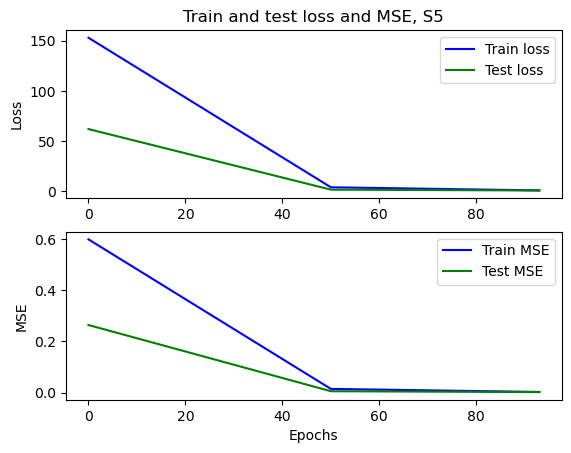

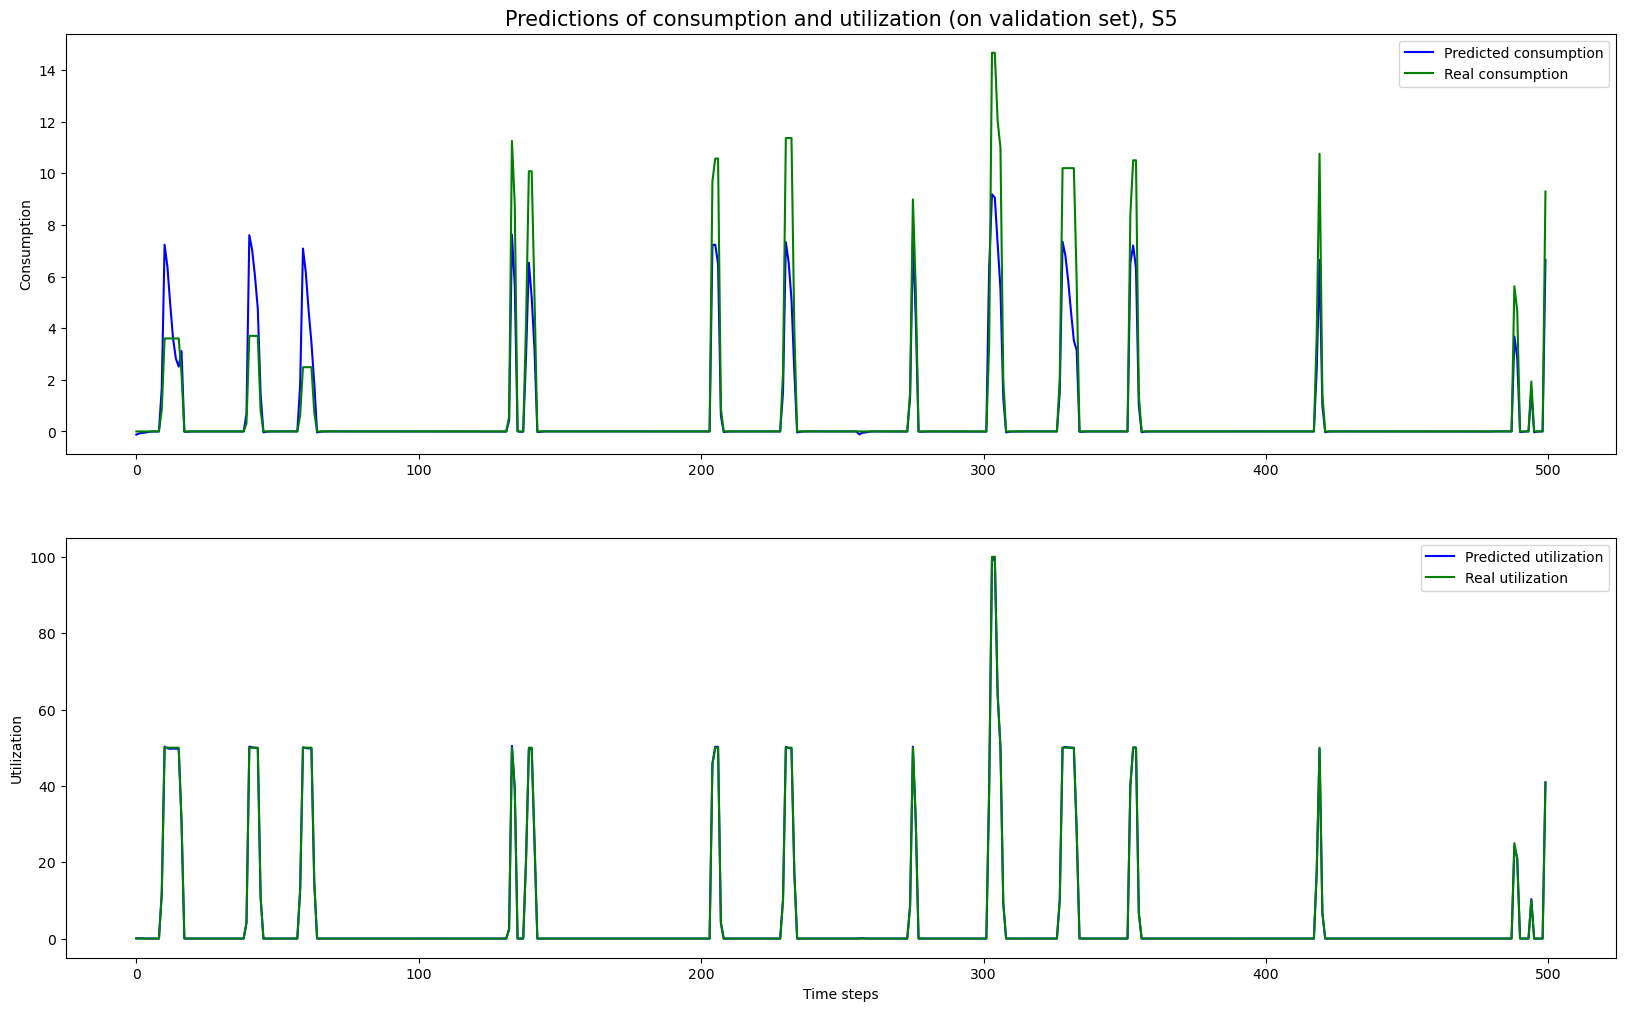

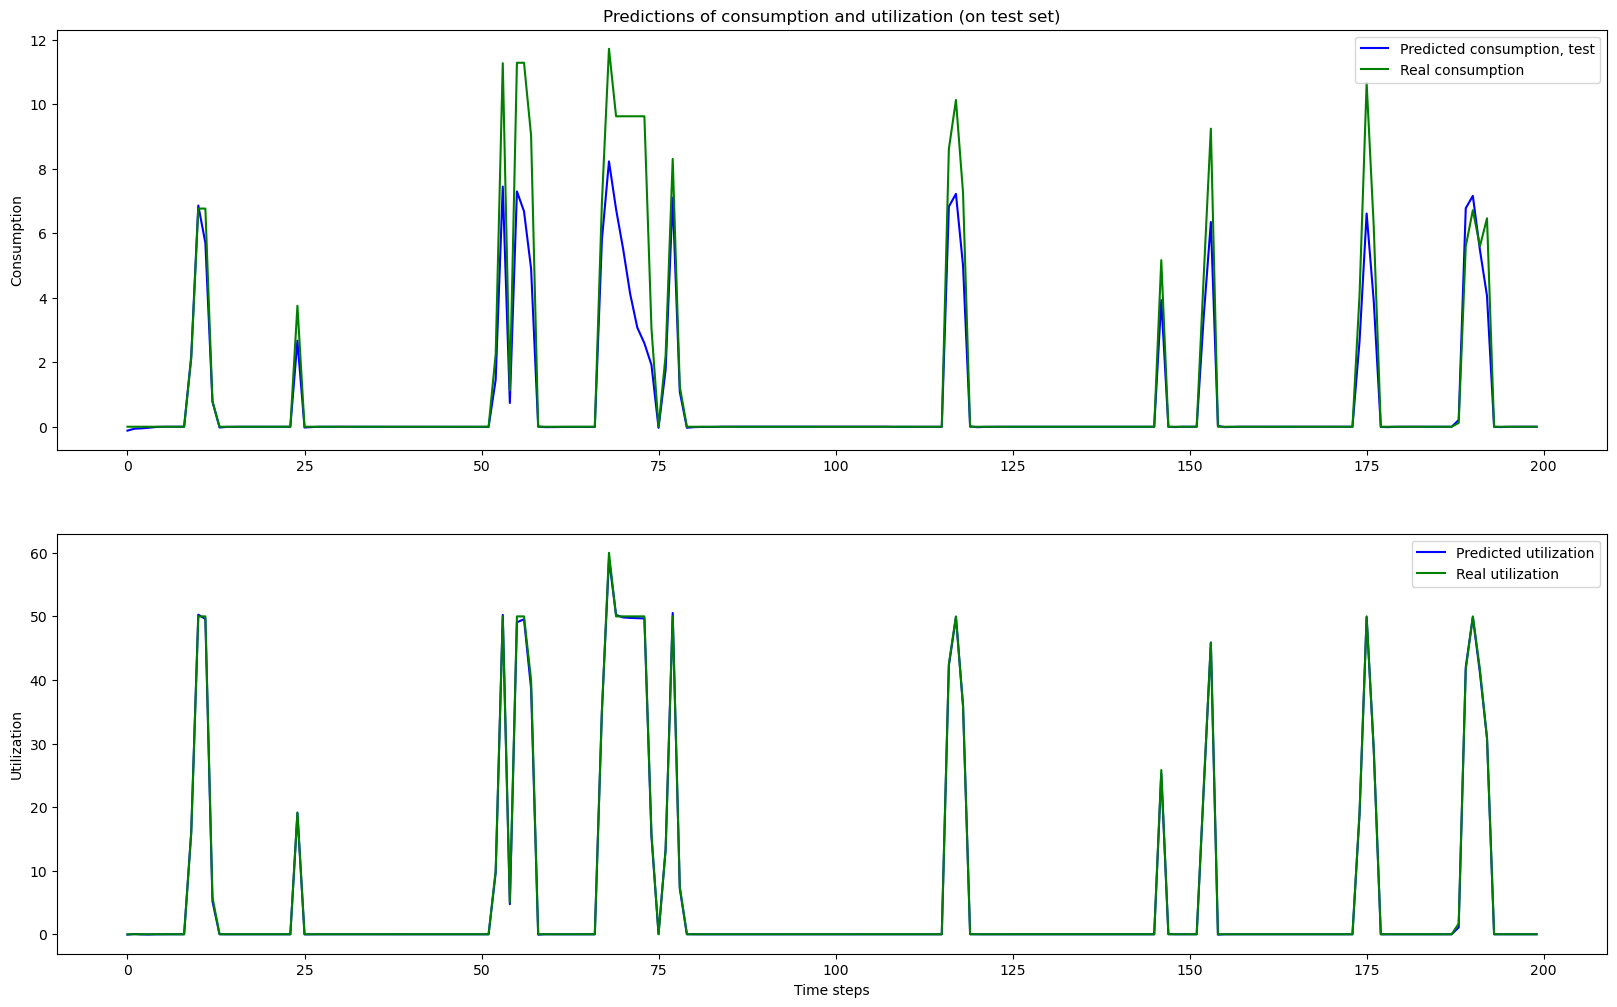

In [223]:
plot_everything(dict_lstm_models_op)

In [104]:
data_diff_setup = pd.DataFrame()

In [105]:
data_diff_setup['S1 P consumption'] = dict_lstm_models_op['Setup 1']['Results']['Predictions consumption test:']
data_diff_setup['S1 R consumption'] = dict_lstm_models_op['Setup 1']['Results']['Real values consumption test:']
data_diff_setup['S1 P utilization'] = dict_lstm_models_op['Setup 1']['Results']['Prediction utilization test:']
data_diff_setup['S1 R utilization'] = dict_lstm_models_op['Setup 1']['Results']['Real values utilization test:']


In [124]:
data_diff_setup['S2 P consumption'] = dict_lstm_models_op['Setup 2']['Results']['Predictions consumption test:']
data_diff_setup['S2 R consumption'] = dict_lstm_models_op['Setup 2']['Results']['Real values consumption test:']
data_diff_setup['S2 P utilization'] = dict_lstm_models_op['Setup 2']['Results']['Prediction utilization test:']
data_diff_setup['S2 R utilization'] = dict_lstm_models_op['Setup 2']['Results']['Real values utilization test:']


In [143]:
data_diff_setup['S3 P consumption'] = dict_lstm_models_op['Setup 3']['Results']['Predictions consumption test:']
data_diff_setup['S3 R consumption'] = dict_lstm_models_op['Setup 3']['Results']['Real values consumption test:']
data_diff_setup['S3 P utilization'] = dict_lstm_models_op['Setup 3']['Results']['Prediction utilization test:']
data_diff_setup['S3 R utilization'] = dict_lstm_models_op['Setup 3']['Results']['Real values utilization test:']


In [160]:
data_diff_setup['S4 P consumption'] = dict_lstm_models_op['Setup 4']['Results']['Predictions consumption test:']
data_diff_setup['S4 R consumption'] = dict_lstm_models_op['Setup 4']['Results']['Real values consumption test:']
data_diff_setup['S4 P utilization'] = dict_lstm_models_op['Setup 4']['Results']['Prediction utilization test:']
data_diff_setup['S4 R utilization'] = dict_lstm_models_op['Setup 4']['Results']['Real values utilization test:']


In [177]:
data_diff_setup['S5 P consumption'] = dict_lstm_models_op['Setup 5']['Results']['Predictions consumption test:']
data_diff_setup['S5 R consumption'] = dict_lstm_models_op['Setup 5']['Results']['Real values consumption test:']
data_diff_setup['S5 P utilization'] = dict_lstm_models_op['Setup 5']['Results']['Prediction utilization test:']
data_diff_setup['S5 R utilization'] = dict_lstm_models_op['Setup 5']['Results']['Real values utilization test:']


In [178]:
data_diff_setup

,S1 P consumption,S1 R consumption,S1 P utilization,S1 R utilization,S2 P consumption,S2 R consumption,S2 P utilization,S2 R utilization,S3 P consumption,S3 R consumption,S3 P utilization,S3 R utilization,S4 P consumption,S4 R consumption,S4 P utilization,S4 R utilization,S5 P consumption,S5 R consumption,S5 P utilization,S5 R utilization
0,-0.002136,0.0,-0.180510,0.0,0.153425,0.0,-0.077317,0.0,0.158429,0.0,0.122218,0.0,-0.026026,0.0,0.026595,0.0,-0.042116,0.0,0.020945,0.0
1,0.034536,0.0,-0.204331,0.0,0.071721,0.0,-0.001621,0.0,0.003548,0.0,0.030073,0.0,-0.007916,0.0,-0.064045,0.0,-0.040690,0.0,-0.003107,0.0
2,0.019811,0.0,-0.097612,0.0,0.055689,0.0,0.008415,0.0,0.003062,0.0,-0.001732,0.0,0.017444,0.0,-0.022946,0.0,-0.033498,0.0,-0.049015,0.0
3,0.018654,0.0,-0.097754,0.0,0.055968,0.0,-0.001703,0.0,0.002139,0.0,0.004826,0.0,0.021604,0.0,0.014157,0.0,-0.018860,0.0,-0.037816,0.0
4,0.020310,0.0,-0.113356,0.0,0.057713,0.0,-0.009387,0.0,0.002264,0.0,0.007471,0.0,0.015052,0.0,0.032721,0.0,-0.007117,0.0,-0.018686,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,0.027303,0.0,-0.158218,0.0,0.063385,0.0,-0.007221,0.0,-0.003016,0.0,0.062342,0.0,-0.002384,0.0,0.017688,0.0,0.006370,0.0,0.018802,0.0
1065,0.027302,0.0,-0.158222,0.0,0.063385,0.0,-0.007215,0.0,-0.003016,0.0,0.062341,0.0,-0.002385,0.0,0.017709,0.0,0.006370,0.0,0.018802,0.0
1066,0.027300,0.0,-0.158223,0.0,0.063385,0.0,-0.007211,0.0,-0.003016,0.0,0.062342,0.0,-0.002386,0.0,0.017729,0.0,0.006370,0.0,0.018802,0.0
1067,0.027299,0.0,-0.158224,0.0,0.063386,0.0,-0.007208,0.0,-0.003016,0.0,0.062341,0.0,-0.002387,0.0,0.017746,0.0,0.006370,0.0,0.018802,0.0


In [179]:
data_diff_setup.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\Scen analiza LSTM 1 stanica.csv', sep=';')

In [226]:
data_diff_setup = pd.read_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\Scen analiza LSTM 1 stanica.csv', sep=';', index_col=[0])

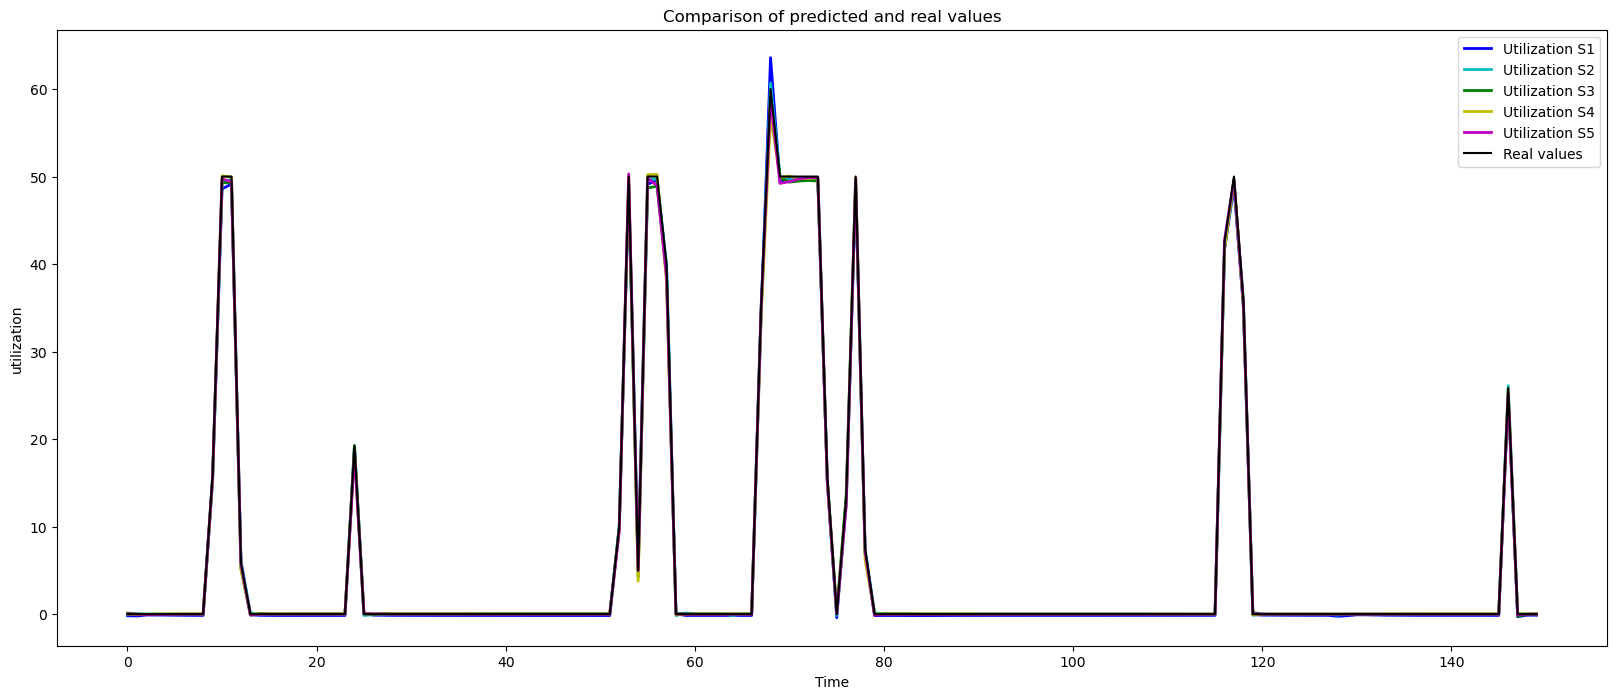

In [230]:
plt.rcParams["figure.figsize"] = (20,8)
    
plt.plot(data_diff_setup['S1 P utilization'].iloc[:150], color='b', linewidth=2, label='Utilization S1')
plt.plot(data_diff_setup['S2 P utilization'].iloc[:150], color='c', linewidth=2, label='Utilization S2')
plt.plot(data_diff_setup['S3 P utilization'].iloc[:150], color='g', linewidth=2, label='Utilization S3')
plt.plot(data_diff_setup['S4 P utilization'].iloc[:150], color='y', linewidth=2, label='Utilization S4')
plt.plot(data_diff_setup['S5 P utilization'].iloc[:150], color='m', linewidth=2, label='Utilization S5')
       
plt.plot(data_diff_setup['S1 R utilization'].iloc[:150], 'k', label='Real values')
plt.ylabel('utilization')
plt.xlabel('Time')
plt.title('Comparison of predicted and real values')
plt.legend()
    
plt.savefig('Scenarijska analiza utilization, Opatija, LSTM.png')
    
plt.show() 

In [224]:
# Save model parameters
torch.save(min_weights, 'lstm_best_model_weights_pickle.pickle')


In [225]:
model

LSTM_TimeSeries(
  (lstm): LSTM(24, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)

In [182]:
min_weights

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.1488, -0.1705,  0.2228,  ..., -0.3951, -0.0301, -0.0303],
                      [-0.0385, -0.0678,  0.2331,  ..., -0.0160,  0.1235, -0.0335],
                      [ 0.0937,  0.0861,  0.0753,  ..., -0.0774, -0.0624,  0.0148],
                      ...,
                      [ 0.0151,  0.1510,  0.1113,  ..., -0.0384,  0.1350,  0.0978],
                      [ 0.0343, -0.0575,  0.0256,  ..., -0.0661, -0.1653, -0.0277],
                      [ 0.1947,  0.2650,  0.0897,  ..., -0.4296,  0.0736,  0.2906]])),
             ('lstm.weight_hh_l0',
              tensor([[-0.1673,  0.0786,  0.0971,  ...,  0.0815, -0.1270,  0.0007],
                      [ 0.1362,  0.0373, -0.0558,  ...,  0.1118, -0.0838,  0.2433],
                      [ 0.1385, -0.0104, -0.0683,  ...,  0.1337,  0.1221, -0.0343],
                      ...,
                      [ 0.1817, -0.2415, -0.1471,  ...,  0.1308,  0.0022,  0.2176],
                      [-0.0156,  

## Transformer model

In [248]:
# Define the Transformer network
class TransformerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, dropout):
        super(TransformerNet, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(input_size, num_heads, hidden_size, dropout),
            num_layers
        )
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, input):
        output = self.transformer(input)
        output = self.fc(output[:, -1, :])
        #output = output.mean(1)
        return output


In [130]:
# Define the dataset for the Transformer
class TransformerDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx+self.sequence_length]
        label = self.data[idx+self.sequence_length]
        return input_seq, label

In [131]:
# Function to calculate the mean squared error
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true.detach().numpy(), y_pred.detach().numpy())

In [165]:
train_data_transformer = TransformerDataset(train_data_filtered, 24)
val_data_transformer = TransformerDataset(val_data_filtered, 24)
test_data_transformer = TransformerDataset(test_data_filtered, 24)

In [149]:
train_data_filtered.labels.shape

torch.Size([8544, 2])

In [166]:
# Define the dataloader for the Transformer
batch_size = 256
transformer_train_dataloader = DataLoader(train_data_transformer, batch_size=batch_size, shuffle=False)
transformer_val_dataloader = DataLoader(val_data_transformer, batch_size=batch_size, shuffle=False)
transformer_test_dataloader = DataLoader(test_data_transformer, batch_size = batch_size, shuffle=False)

In [167]:
for x,y in transformer_train_dataloader:
    print(x[1].shape, y[1].shape)
    break

torch.Size([256, 24, 2]) torch.Size([256, 2])


In [242]:
# same thing as for the LSTM model - this dictionary is only used for storing
dict_transformer_model_op = {}

In [243]:
dict_transformer_model_op['Setup'] = {}

In [244]:
dict_transformer_model_op['Setup']['Parameters'] = {'batch size': 256,
                                                   'lookback': 24,
                                                   'hidden size': 64,
                                                   'num layers': 3,
                                                    'num heads': 6,
                                                   'learning rate': 0.001,
                                                   'optimizer': 'RMSprop'}

In [245]:
dict_transformer_model_op['Setup']['Results'] = {}

In [249]:
train_loss_list = []
train_mse_list = []
test_loss_list = []
test_mse_list = []
epoch_list = []
predicted_values_consumption = pd.DataFrame()
predicted_values_utilization = pd.DataFrame()
real_values_consumption = pd.DataFrame()
real_values_utilization = pd.DataFrame()

pred_consumption_test = pd.DataFrame()
pred_utilization_test = pd.DataFrame()
real_consumption_test = pd.DataFrame()
real_utilization_test = pd.DataFrame()


In [187]:
y[1][0]

tensor([0., 0.])

In [162]:
transformer_train_dataloader.dataset.data.features.shape[1]

24

In [251]:
# Define the Transformer network
input_size = transformer_train_dataloader.dataset.data.features.shape[1]
hidden_size = 64
output_size = transformer_train_dataloader.dataset.data.labels.shape[1]
num_layers = 3
num_heads = 6
dropout = 0.1
model = TransformerNet(input_size, hidden_size, output_size, num_layers, num_heads, dropout)
len_train_data = train_data_transformer.data.features.shape[0]
len_val_data = val_data_transformer.data.features.shape[0]
len_test_data = test_data_transformer.data.features.shape[0]

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
counter = 0

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_mse = 0.0
    val_mse = 0.0
    
    # Training
    model.train()
    for inputs, labels in transformer_train_dataloader:
        optimizer.zero_grad()
        inputs = inputs[0]
        real_outputs_train = labels[1]
        outputs_train = model(inputs)
        loss = criterion(outputs_train, real_outputs_train)

        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_mse += calculate_mse(real_outputs_train, outputs_train)
    #print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss/len_train_data:.4f} - Train MSE: {train_mse/len_train_data:.4}")
    
    predicted_values_pom1 = []
    predicted_values_pom2 = []
    real_values_pom1 = []
    real_values_pom2 = []
    
    # Testing
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in transformer_val_dataloader:
            inputs_val = inputs[0]
            real_outputs_val = labels[1]
            outputs_val = model(inputs_val)
            loss = criterion(outputs_val, real_outputs_val)
            
            predicted_values_pom1 += outputs_val.numpy()[:, 0].tolist()
            predicted_values_pom2 += outputs_val.numpy()[:, 1].tolist()
            real_values_pom1 += real_outputs_val.numpy()[:, 0].tolist()
            real_values_pom2 += real_outputs_val.numpy()[:, 1].tolist()
            val_loss += loss.item() * inputs_val.size(0)
            val_mse += calculate_mse(real_outputs_val, outputs_val)
            
            #val_loss += loss.item() * inputs_val.size(0)
            #val_mse += calculate_mse(real_outputs_val, outputs_val)
    
    if epoch%20 == 0:
        # Print training and test errors
        print(f"Epoch {epoch}/{num_epochs} - Training Loss: {train_loss/len_train_data:.4f} - Val Loss: {val_loss/len_val_data:.4f} - Train MSE: {train_mse/len_train_data:.4f} - Val MSE: {val_mse/len_val_data:.4f}")
        train_loss_list.append(train_loss/len_train_data)
        train_mse_list.append(train_mse/len_train_data)
        test_loss_list.append(val_loss/len_val_data)
        test_mse_list.append(val_mse/len_val_data)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        
    if epoch == 0:
        real_values_consumption['Epoch ' + str(epoch)] = real_values_pom1
        real_values_utilization['Epoch ' + str(epoch)] = real_values_pom2
        val_loss_old = (val_loss/len_val_data)
        
        min_val_loss = val_loss_old
        min_weights = model.state_dict()
        
    if epoch > 0:
        val_loss_new = val_loss/len_val_data
        if val_loss_new > min_val_loss: # some kind of an Early Stopping callback
            counter += 1
        else:
            min_val_loss = val_loss_new
            min_weights = model.state_dict()
            predicted_values_consumption['The best epoch'] = predicted_values_pom1
            predicted_values_utilization['The best epoch'] = predicted_values_pom2
            #print('Epoch: ', epoch)
            #print('Minimum validation loss: ', min_val_loss)
            

    if counter == 100: 
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train MSE: {train_mse/len_train_data:.4f} - Val MSE: {val_mse/len_val_data:.4f}")
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train loss: {train_loss/len_train_data:.4f} - Val loss: {val_loss/len_val_data:.4f}")
        print('Minimum validation loss: ', min_val_loss)
        print('Current validation loss: ', val_loss_new)
        train_loss_list.append(train_loss/len_train_data)
        train_mse_list.append(train_mse/len_train_data)
        test_loss_list.append(val_loss/len_val_data)
        test_mse_list.append(val_mse/len_val_data)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        break


Epoch 0/1000 - Training Loss: 171.9601 - Val Loss: 74.4979 - Train MSE: 0.6758 - Val MSE: 0.3690
Epoch 20/1000 - Training Loss: 69.1920 - Val Loss: 39.8903 - Train MSE: 0.2719 - Val MSE: 0.2266
Epoch 40/1000 - Training Loss: 55.4041 - Val Loss: 37.2767 - Train MSE: 0.2180 - Val MSE: 0.2141
Epoch 60/1000 - Training Loss: 51.8929 - Val Loss: 36.8706 - Train MSE: 0.2045 - Val MSE: 0.2113
Epoch 80/1000 - Training Loss: 51.5852 - Val Loss: 36.8170 - Train MSE: 0.2030 - Val MSE: 0.2103
Epoch 100/1000 - Training Loss: 50.9253 - Val Loss: 36.6342 - Train MSE: 0.2005 - Val MSE: 0.2075
Epoch 120/1000 - Training Loss: 51.0135 - Val Loss: 36.6122 - Train MSE: 0.2011 - Val MSE: 0.2078
Epoch 140/1000 - Training Loss: 50.7333 - Val Loss: 37.2794 - Train MSE: 0.1998 - Val MSE: 0.2236
[Early stopping] Epoch 140/1000 - Train MSE: 0.1998 - Val MSE: 0.2236
[Early stopping] Epoch 140/1000 - Train loss: 50.7333 - Val loss: 37.2794
Minimum validation loss:  36.46428568979328
Current validation loss:  37.2794

In [252]:
sum(p.numel() for p in model.parameters())

17018

In [253]:
outputs_train.shape

torch.Size([72, 2])

In [254]:
# the prediction part
pred_consumption = []
pred_utilization = []
real_consumption = []
real_utilization = []

test_loss = 0.0
test_mse = 0.0

for inputs, labels in transformer_test_dataloader:
    inputs_test = inputs[0]
    real_outputs_test = labels[1]
    outputs_test = model(inputs_test)
    loss = criterion(outputs_test, real_outputs_test)
    # print('Outputs shape: ', outputs.squeeze().shape)
    pred_consumption += outputs_test.detach().numpy()[:, 0].tolist()
    pred_utilization += outputs_test.detach().numpy()[:, 1].tolist()
    real_consumption += real_outputs_test.numpy()[:, 0].tolist()
    real_utilization += real_outputs_test.numpy()[:, 1].tolist()
    test_loss += loss.item() * inputs_test.size(0)
    test_mse += calculate_mse(real_outputs_test, outputs_test)

pred_consumption_test['Final'] = pred_consumption
pred_utilization_test['Final'] = pred_utilization
real_consumption_test['Final'] = real_consumption
real_utilization_test['Final'] = real_utilization


In [255]:
dict_transformer_model_op['Setup']['Results'] = {'Train loss': train_loss_list,
                              'Train MSE': train_mse_list,
                              'Test loss': test_loss_list,
                              'Test MSE': test_mse_list,
                              'Epochs': epoch_list,
                              'Predictions consumption validation:': predicted_values_consumption,
                              'Prediction utilization validation:': predicted_values_utilization,
                              'Real values consumption validation:': real_values_consumption,
                               'Real values utilization validation:': real_values_utilization,
                              'Predictions consumption test:': pred_consumption_test,
                              'Prediction utilization test:': pred_utilization_test,
                              'Real values consumption test:': real_consumption_test,
                               'Real values utilization test:': real_utilization_test}

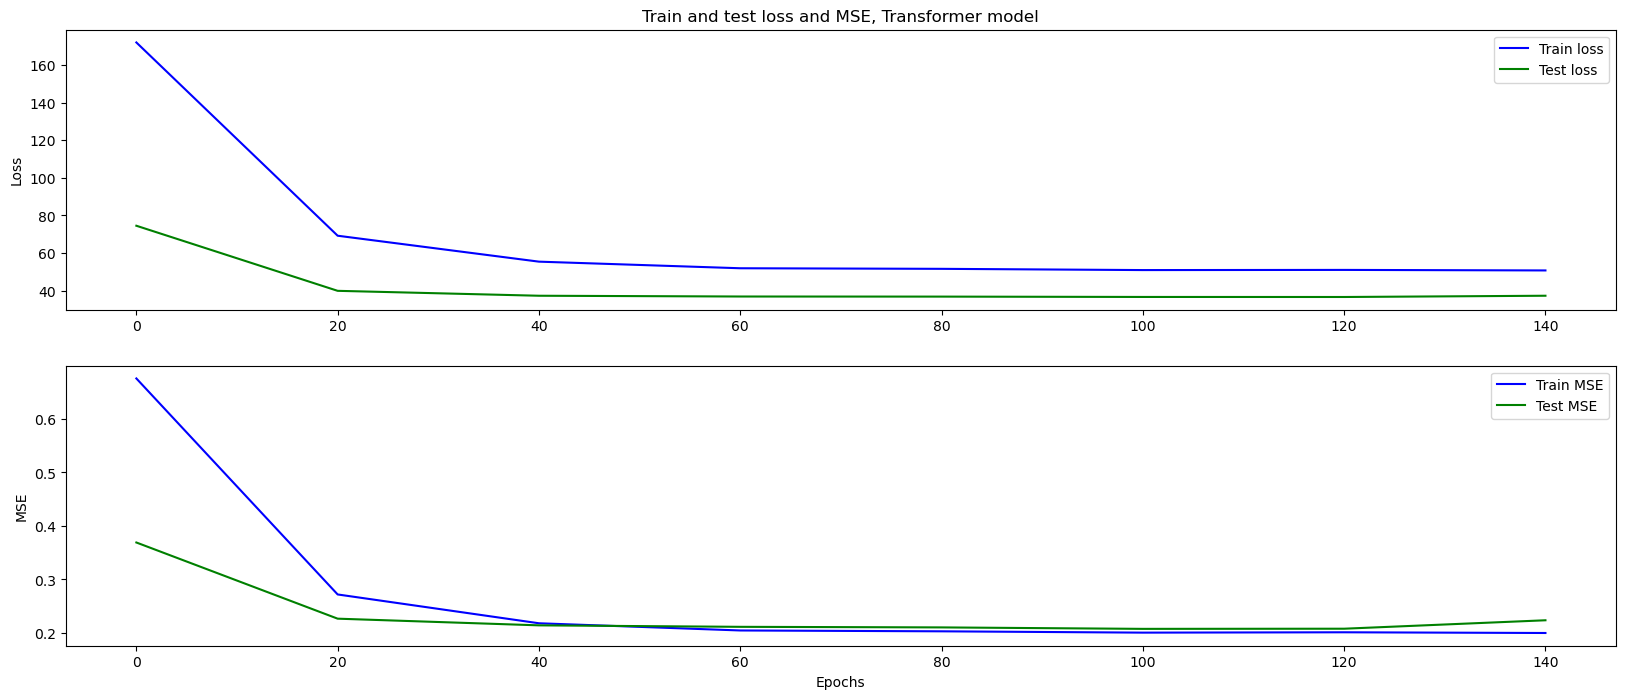

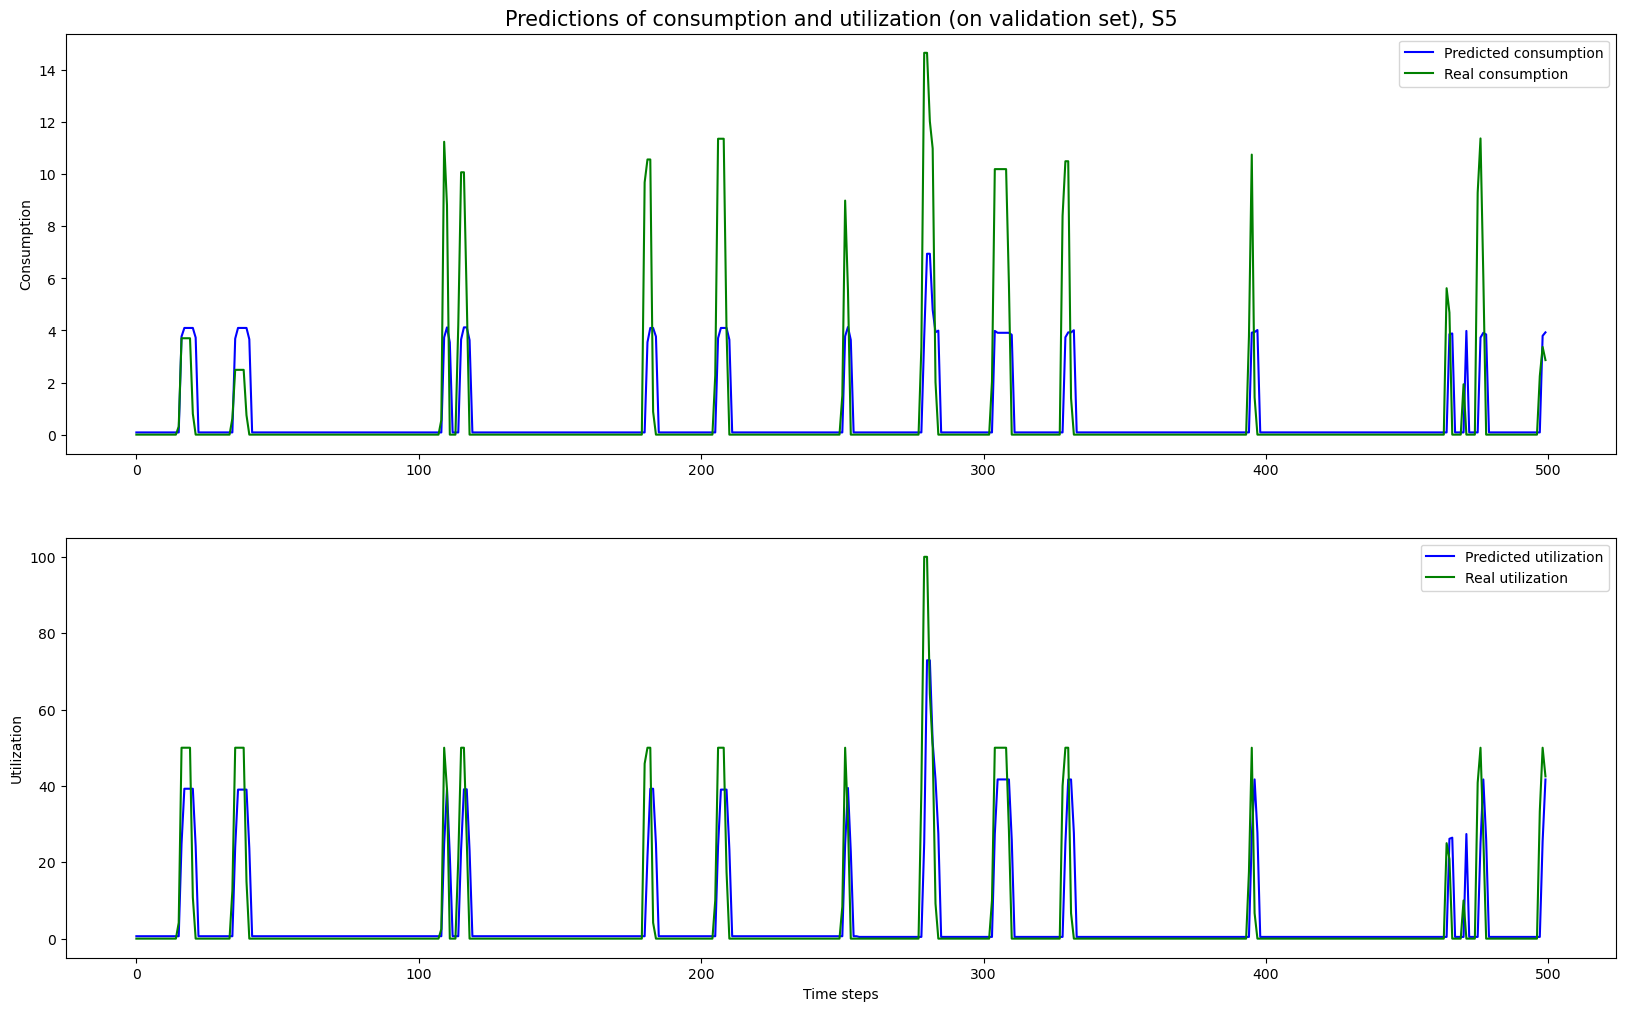

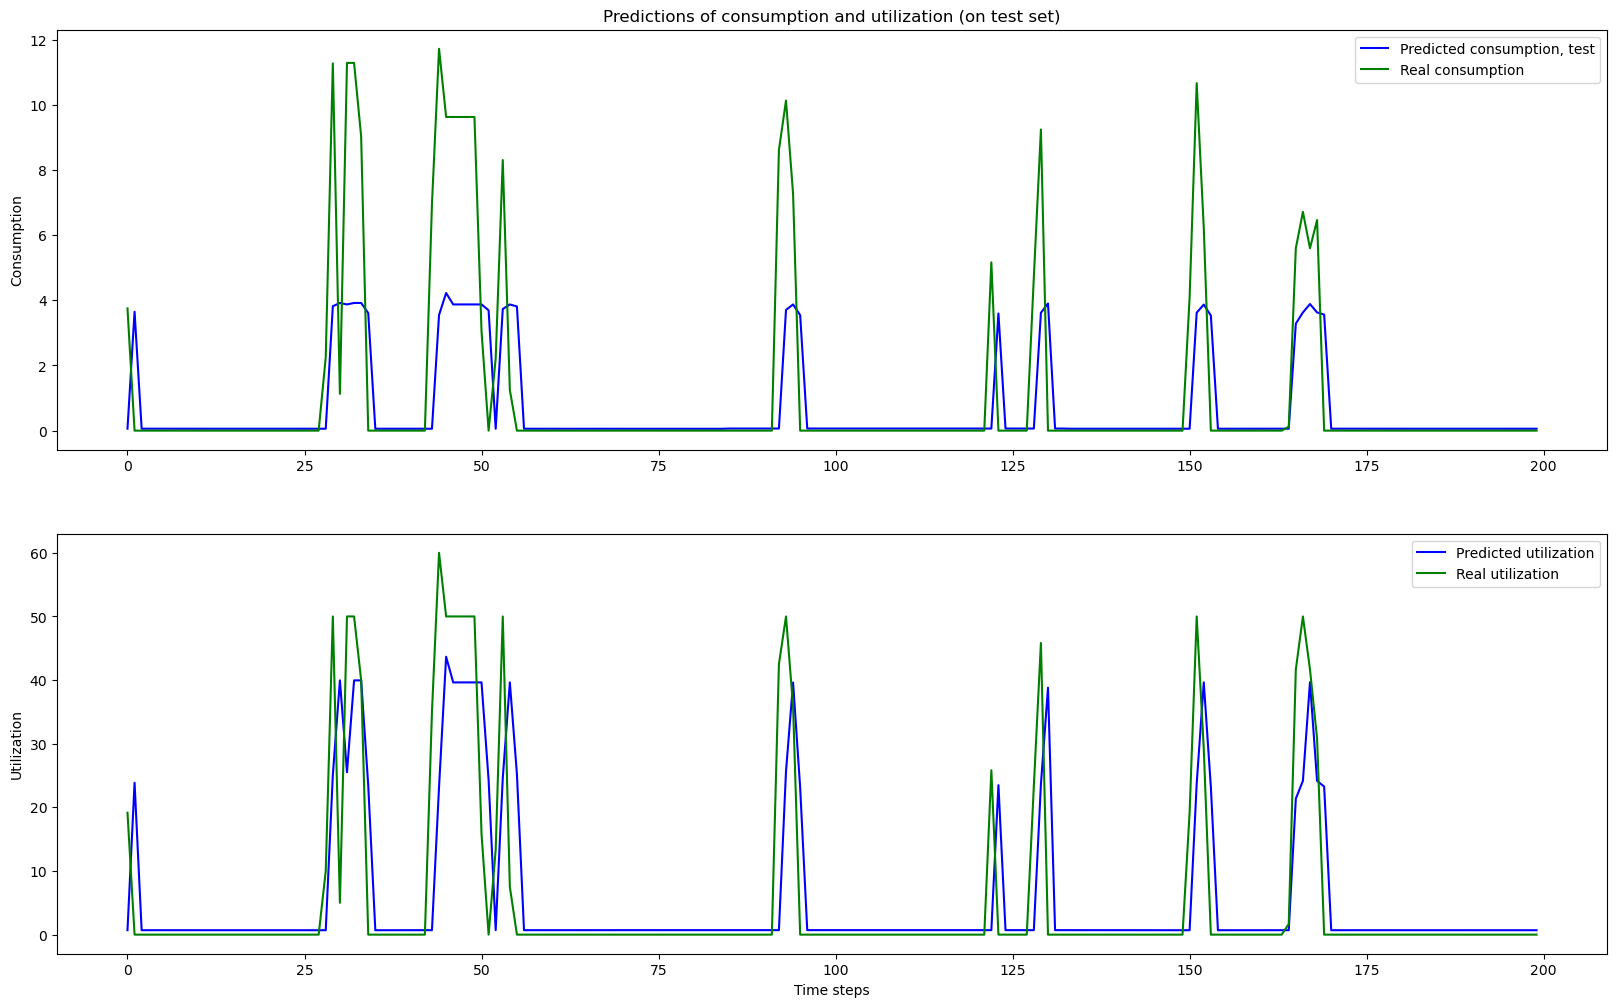

In [256]:
plot_everything(dict_transformer_model_op)

In [468]:
real_outputs_test.shape

torch.Size([62, 2])

## ARIMA baseline

In [436]:
train_size = int(len(filter_data_new) * 0.8)
test_size = len(filter_data_new) - train_size
train_data, test_data = filter_data_new[:train_size], filter_data_new[train_size:]

In [437]:
# Prepare the dataset for ARIMA
dataset = TimeSeriesDataset(filter_data_new)
data = dataset.labels.numpy().squeeze()  # Assuming dataset.labels is a PyTorch tensor
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]


In [440]:
filter_data_new

,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Year,Month,Day
Time,,,,,,,,,,
2022-01-01 17:00:00,Public access - Free access,2022-01-01 17:00:00+00,23.333333,3,0,6.114263,42,52,1,5
2022-01-01 18:00:00,Public access - Free access,2022-01-01 18:00:00+00,5.000000,3,0,1.276126,9,52,1,5
2022-01-01 19:00:00,Public access - Free access,2022-01-01 19:00:00+00,33.333333,3,1,8.507505,60,52,1,5
2022-01-01 20:00:00,Public access - Free access,2022-01-01 20:00:00+00,21.111111,3,0,5.388086,38,52,1,5
2022-01-02 08:00:00,Public access - Free access,2022-01-02 08:00:00+00,2.222222,3,0,0.209307,4,52,1,6
...,...,...,...,...,...,...,...,...,...,...
2022-10-31 12:00:00,Public access - Free access,2022-10-31 12:00:00+00,14.444444,3,0,20.342183,26,52,10,0
2022-10-31 14:00:00,Public access - Free access,2022-10-31 14:00:00+00,3.333333,3,0,0.330101,6,52,10,0
2022-10-31 15:00:00,Public access - Free access,2022-10-31 15:00:00+00,5.000000,3,0,0.495152,9,52,10,0


In [452]:
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

# Train the ARIMA model
order = (3, 1, 2)  # Example order, you can adjust these values -> we should try with different #configurations
season_order = (1,1,1,7)
model = ARIMA(train_data, order=order, seasonal_order=season_order)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=train_size, end=len(data)-1)

# Calculate MSE
train_mse = calculate_mse(train_data, model_fit.fittedvalues)
test_mse = calculate_mse(test_data, predictions)

# Print training and test errors
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")



C:\Users\ZVNE\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ZVNE\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training MSE: 79.8920
Test MSE: 116.3601


In [450]:
predictions

array([ 5.10885833,  2.25414411, 11.72813074, 17.51780428,  4.32610502,
        1.0569364 ,  8.97898749, 11.24428546,  4.98050194,  1.38714099,
       10.38470745, 13.9508948 ,  4.78592167,  1.18312498,  9.81292978,
       12.70974991,  4.91051655,  1.26489595, 10.09472345, 13.26608994,
        4.87302617,  1.23233836,  9.98298422, 13.0232314 ,  4.90258464,
        1.25534269, 10.04475486, 13.14147006,  4.90031044,  1.25469275,
       10.02768102, 13.09832144,  4.91179925,  1.26505222, 10.04571028,
       13.12783514,  4.91694989,  1.27058828, 10.04789359, 13.1247961 ,
        4.92489716,  1.27832563, 10.0571634 , 13.13638988,  4.93157428,
        1.28508578, 10.06324394, 13.14142102,  4.93881709,  1.29228791,
       10.07075368, 13.14939996,  4.9458046 ,  1.29929265, 10.0776211 ,
       13.15605618,  4.9529063 ,  1.30638631, 10.08477663, 13.16330635,
        4.95995662,  1.31344014, 10.09180275, 13.17028994,  4.96702996,
        1.32051188, 10.09888695, 13.17739321,  4.97409296,  1.32

In [367]:
test_data.shape

(154,)

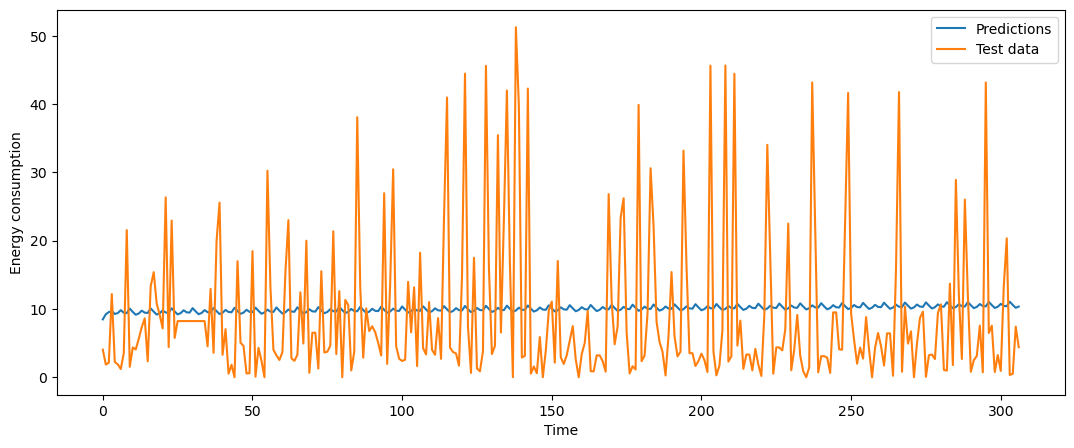

In [453]:
plt.plot(predictions, label='Predictions')
plt.plot(test_data, label='Test data')
plt.ylabel('Energy consumption')
plt.xlabel('Time')
plt.legend()
plt.savefig('ARIMA s3, Osijek.png')
plt.show()

In [83]:
dict_values['ARIMA'] = {}

In [84]:
dict_values['ARIMA']['train_mse'] = train_mse
dict_values['ARIMA']['test_mse'] = test_mse
dict_values['ARIMA']['order'] = order


In [57]:
model.weights

AttributeError: 'ARIMA' object has no attribute 'weights'

## Storing results

In [ ]:
dict_values['LSTM'] = {}


In [27]:
model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.0113, -0.0461,  0.1429,  ..., -0.2885,  0.1183,  0.1100],
                      [ 0.1115,  0.0959,  0.0874,  ..., -0.1748,  0.1228,  0.0447],
                      [-0.0283,  0.1456, -0.1351,  ..., -0.0832, -0.1858, -0.2421],
                      ...,
                      [-0.2133, -0.0556, -0.0009,  ..., -0.0225, -0.3305, -0.0825],
                      [ 0.0891,  0.0461, -0.0499,  ...,  0.2056, -0.5657, -0.0501],
                      [-0.1536, -0.0612, -0.0724,  ..., -0.2989, -0.3075,  0.1252]])),
             ('lstm.weight_hh_l0',
              tensor([[-0.0977, -0.0554,  0.1368,  ..., -0.1598, -0.0480,  0.1419],
                      [-0.1098,  0.1198, -0.2511,  ...,  0.1241, -0.1510, -0.3679],
                      [-0.0049, -0.0936,  0.1898,  ..., -0.0491, -0.1986,  0.0674],
                      ...,
                      [ 0.5127,  0.0677, -0.1379,  ...,  0.0226, -0.1515,  0.0549],
                      [-0.4112, -